# Plots and analyses for: The development of complex planning
This notebook contains the main plots and analyses for Four in a row development data. 
## 1.1 load packages and data


In [307]:
import numpy as np
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as sts
import pandas as pd
import seaborn as sns
from matplotlib import rcParams,font_manager
from matplotlib.colors import ListedColormap
from pymer4.models import Lmer
%reload_ext rpy2.ipython

from fourinarowfunctions import *

datadir = "../data/"
age = pd.read_csv(datadir + "SubjectAge.csv")
pwm = pd.read_csv(datadir + "params_with_metrics.csv")
dur = pd.read_csv(datadir + "gameDurations.csv")
rts = pd.read_csv(datadir + "reactiontimes.csv")
trialdf = pd.read_csv(datadir + "trialdata.csv")
LL = pd.read_csv(datadir + "paramsLogLikelihoodsLong.csv")
NLL_wide = pd.read_csv(datadir + "paramsLogLikelihoodswide.csv")

In [127]:
%%R
#load R packages and data files
library(lme4)
library(ggplot2)
options(repr.plot.width=10, repr.plot.height=8)
library(sjPlot)
library(RColorBrewer)
library(stargazer)
library("tidyr")

## 1.2 Data check and create dataframes

In [128]:
pwm["subject"].value_counts()


202:R_2OHMsGSLXJZG0Bc      5
875:R_sRIghBHHMf7ejap      5
329:R_23eNWjNjj4QQj6j      5
A1184:R_28HW4qAaDytUum4    5
216:R_21j62EoiJ63yEJ5      5
                          ..
A121:R_3j2tErwVrBPXWAH     5
A1157:R_0GqMhnxN1UuSyZP    5
A101:R_Q0Jd5lCBrQu5Dm9     5
175:R_2vjnTMhG0Bpa7wq      5
890:R_3k6BHPoEBivOVoU      5
Name: subject, Length: 158, dtype: int64

In [129]:
#name of your data file
filename = datadir + 'trialdata.csv'
data_dict = load_data(filename, False)
parsed_dict = {}
for username, data in data_dict.items():
    try:
        parsed_dict[username] = get_parsed_data(data)
    except AssertionError as e:
        continue
usernames = parsed_dict.keys()
print(f"{len(usernames)} users with complete data")

158 users with complete data


In [130]:
rcParams['font.family'] = "sans-serif" 
rcParams['font.weight'] = "roman" 
rcParams['font.style'] = "normal" # not 100% sure what this does but it was recommended
rcParams['font.size'] = 32 # not 100% sure what this does but it was recommended
rcParams['pdf.fonttype'] = 42
rcParams['axes.linewidth'] = 2 #thickness of the border
rcParams['xtick.major.width'] = rcParams['axes.linewidth'] # make sure line widths are consistent
rcParams['ytick.major.width'] = rcParams['axes.linewidth']
rcParams['axes.spines.right'] = False #hides right border
rcParams['axes.spines.top'] = False #hides top
rcParams['legend.frameon'] = False #hides box around the legend
rcParams['legend.fontsize'] = 18 #font size in pt
rcParams['axes.labelsize'] = 32 
rcParams['xtick.labelsize'] = 24
rcParams['ytick.labelsize'] = rcParams['xtick.labelsize']
rcParams['lines.linewidth'] = 3
rcParams['xtick.major.size'] = 5
rcParams['lines.markersize'] = 16
rcParams['ytick.major.size'] = rcParams['xtick.major.size']

username2studyid = {username: username.split(":")[0] for username in usernames}
username2psiturkid = {username: username.split(":")[1] for username in usernames}

Users that have the same StudyID

Should be empty

In [131]:
duplicates = pd.DataFrame(username2studyid.items(), columns=["username", "StudyID"])
duplicates[duplicates["StudyID"].duplicated(keep=False)]

,username,StudyID
92,866:R_1gV06gSb8WYiLyG,866
110,866:R_31YEgt5MqfcfZMC,866


In [132]:
#create age bins and dataframes

bins = [7, 12, 18, 25]
ageBinrNr2Value = {0: 10, 1: 15, 2:21}
age['ageBin'] = pd.cut(age['FlooredAge'], bins)
age['ageBinNr'] = age['ageBin'].cat.codes
age['ageBinValue'] = age.apply(lambda row: ageBinrNr2Value.get(row['ageBinNr'], 0), axis = 1)
dur["MainDurationMinutes"] = pd.to_numeric(dur["MainDurationSeconds"]) / 60
dur["TotalDurationMinutes"] = pd.to_numeric(dur["TotalDurationSeconds"], errors='coerce') / 60
dur["StudyID"] = dur["User"].apply(lambda x: username2studyid[x])
rts["TotalMoves"] = rts["UserMoves"] + rts["OpponentMoves"]
rts["StudyID"] = rts["User"].apply(lambda x: username2studyid[x])
gameCat = pd.merge(rts, age, on="StudyID", how="left")
raw_metrics = pwm.loc[:,("subject", "fold", "planning depth", "feature drop rate", "heuristic quality", "elo")]
raw_metrics["StudyID"] = raw_metrics["subject"].apply(lambda x: username2studyid[x])
raw_metrics = pd.merge(raw_metrics, age, on="StudyID", how="left")
metrics = raw_metrics.dropna()

dropped_nans = raw_metrics[~raw_metrics.index.isin(metrics.index)]
print(f"Dropped rows with nans: {len(dropped_nans)}")
dropped_nans

Dropped rows with nans: 10


,subject,fold,planning depth,feature drop rate,heuristic quality,elo,StudyID,DoB,Gender,ExactAge,FlooredAge,TaskDate,ageBin,ageBinNr,ageBinValue
615,A1153:R_1CwnNA5xXOlHq5l,1,0.007242,0.47066,0.388199,-116,A1153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
616,A1153:R_1CwnNA5xXOlHq5l,2,2.894970,0.48038,0.354045,-116,A1153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
617,A1153:R_1CwnNA5xXOlHq5l,3,3.124830,0.31274,0.339734,-116,A1153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
618,A1153:R_1CwnNA5xXOlHq5l,4,7.923260,0.56622,0.230695,-116,A1153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
619,A1153:R_1CwnNA5xXOlHq5l,5,2.879000,0.41566,0.249818,-116,A1153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
670,A1186:R_25X9yP84u29qmjb,1,0.524918,0.23315,0.284018,-62,A1186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
671,A1186:R_25X9yP84u29qmjb,2,0.104779,0.30366,0.231405,-62,A1186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
672,A1186:R_25X9yP84u29qmjb,3,4.499510,0.37594,0.154002,-62,A1186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
673,A1186:R_25X9yP84u29qmjb,4,3.738730,0.37240,0.094728,-62,A1186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
674,A1186:R_25X9yP84u29qmjb,5,1.424640,0.30716,0.289428,-62,A1186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
#drop the double subject
metrics = metrics[~metrics.subject.str.contains("R_31YEgt5MqfcfZMC")]
metrics["subject"].nunique()

155

In [134]:
#decisions per game
rts.head()
rts1 = rts.groupby('StudyID').mean()
rts1.mean()
rts1.std()

GameNr            0.895724
Category          2.298001
Level            22.855103
MoveNr            0.707250
RT                1.014955
UserMoves         1.414095
OpponentMoves     1.435856
TotalMoves        2.849190
dtype: float64

# 2.0 create figures
## 2.1 model derived metrics

In [135]:
age_colors = ['#7DE3AC', '#129951','#20382B']
age_labels = ["8 to 12","13 to 17","18 to 25"]

rcParams['figure.figsize'] = (8,6) #figure size in inches

def set_labels(ax, title, reposition_ticks = True):
    ax.set_xlabel("Age")
    ax.set_ylabel(title)
    labels = age_labels.copy()
    if reposition_ticks:
        ax.set_xticks(list(ageBinrNr2Value.values()))
    ax.set_xticklabels(labels)
    ax.legend([])
    return ax

def plot_with_errorbars(col, title, df = None):
    if not isinstance(df, pd.DataFrame):
        df = metrics.groupby("subject").mean().reset_index()
    ax = df.groupby("ageBinValue")[col].aggregate(['mean', 'sem']).plot(yerr="sem", color='k')
    size = 20
   # df.plot.scatter('ExactAge', col, size, [age_colors[int(binNr)] for binNr in df['ageBinNr']], ax=ax)
    size = 300
    df.groupby("ageBinValue")[col].aggregate(['mean']).reset_index().plot.scatter('ageBinValue', 'mean', size, age_colors, ax=ax)
    print(f"{len(df.dropna(subset=[col]))} rows used in this graph")
    set_labels(ax, title)

155 rows used in this graph


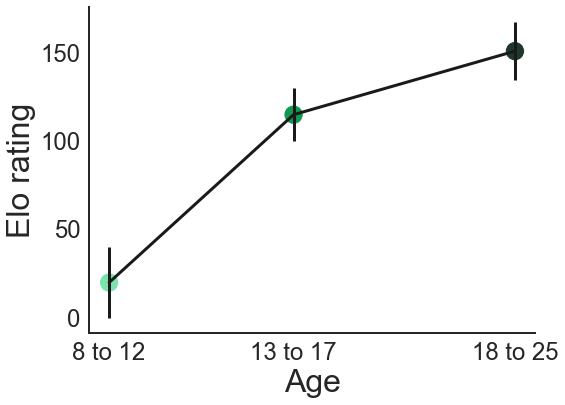

In [136]:
plot_with_errorbars("elo", "Elo rating")

155 rows used in this graph


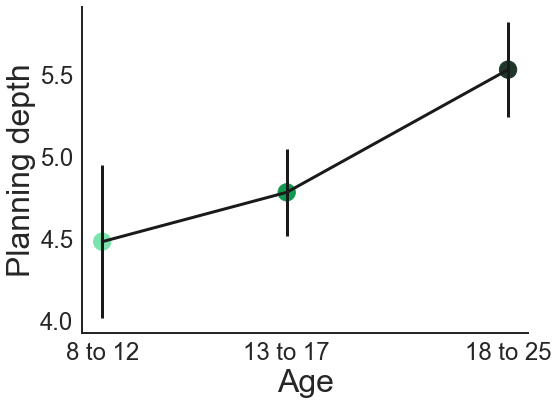

In [137]:
plot_with_errorbars("planning depth", "Planning depth")

155 rows used in this graph


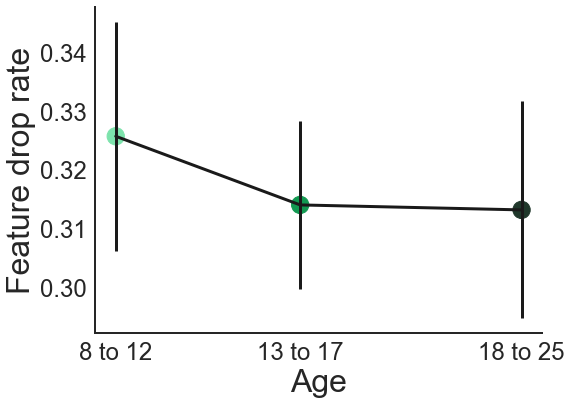

In [138]:
plot_with_errorbars("feature drop rate", "Feature drop rate")

155 rows used in this graph


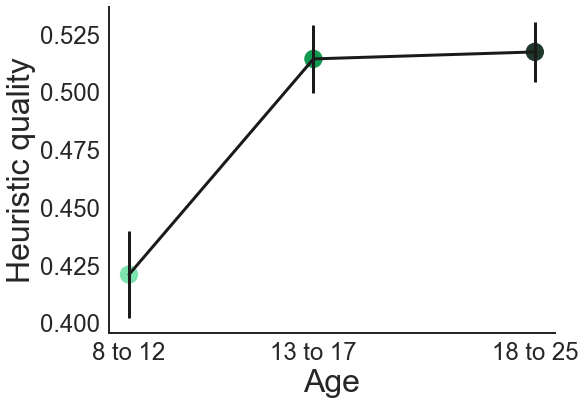

In [139]:
plot_with_errorbars("heuristic quality", "Heuristic quality")

## 2.2 game duration

In [140]:
durage = pd.merge(dur, age, how="left", on="StudyID")
print(f"Subjects in data: {len(durage)}")
# only include subjects listed in the first cell
durage = durage[durage["User"].isin(usernames)]
print(f"Subjects after selection: {len(durage)}")
# Remove duplicate subjects. Duplicates creep in if on or both of params_with_metrics or the age csv's contains duplicates
durage = durage.drop_duplicates(subset=["User"], keep="first")
print(f"Subjects after filtering duplicates: {len(durage)}")
# Drop subjects for which no age was available. Check that you have the expected number of subjects left!
durage = durage.dropna(subset=["ageBin"])
print(f"Subjects with age bin: {len(durage)}")

Subjects in data: 158
Subjects after selection: 158
Subjects after filtering duplicates: 158
Subjects with age bin: 156


In [141]:
rcParams['figure.figsize'] = (6,6) #figure size in inches

def plot_freq(col, title):
    plotdata = durage.groupby("ageBin")[col].aggregate(['mean', 'sem'])
    ax = plotdata.plot(kind="bar", yerr="sem", color=[age_colors])
    set_labels(ax, title, False).tick_params("x", labelrotation=0)

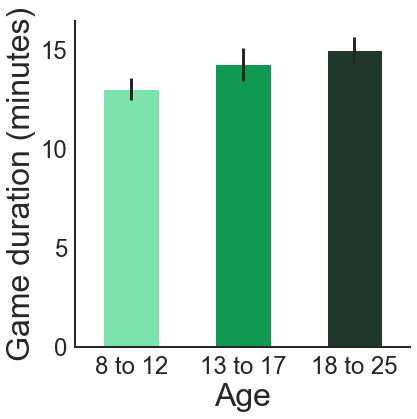

In [142]:
plot_freq("MainDurationMinutes", "Game duration (minutes)")

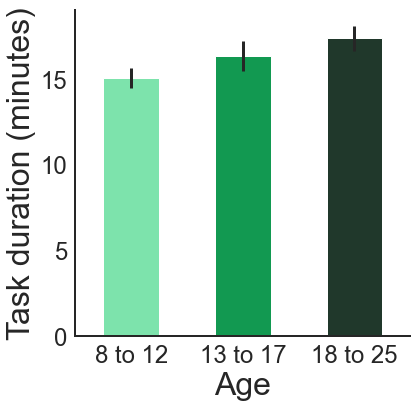

In [143]:
plot_freq("TotalDurationMinutes", "Task duration (minutes)")

In [144]:
plotdata = pd.merge(rts, age, on="StudyID", how="left")[["User", "GameNr", "TotalMoves", "ageBinNr"]].drop_duplicates()
plotdata = plotdata[plotdata["ageBinNr"] >= 0]
plotdata["count"] = 1
plotdata = plotdata.groupby(["ageBinNr", "TotalMoves"])["count"].sum().reset_index().pivot(index="TotalMoves",columns="ageBinNr").fillna(0)
plotdata.loc[37] = 0 # Add an empty value at the end (36 moves is a full board)
plotdata = plotdata.sort_index()

subsPerBin = metrics[["subject", "ageBinNr"]].drop_duplicates().groupby("ageBinNr").count()
for binNr in range(len(bins) - 1):
    plotdata.iloc[:,binNr] = plotdata.iloc[:,binNr] / subsPerBin.iloc[binNr,0]

plotdata

count                    
ageBinNr         0.0       1.0       2.0
TotalMoves                              
6           0.000000  0.000000  0.022222
7           7.727273  7.236364  6.155556
8           4.490909  4.236364  3.866667
9           2.527273  2.672727  2.844444
10          2.109091  2.472727  2.133333
11          2.818182  2.818182  3.311111
12          1.745455  2.218182  2.511111
13          1.909091  2.418182  2.288889
14          1.981818  1.763636  1.866667
15          1.709091  1.618182  1.466667
16          1.127273  1.309091  1.022222
17          1.109091  1.290909  1.355556
18          0.800000  0.727273  1.200000
19          0.690909  0.800000  0.577778
20          0.545455  0.581818  0.688889
21          0.436364  0.490909  0.622222
22          0.309091  0.418182  0.444444
23          0.381818  0.272727  0.377778
24          0.290909  0.218182  0.200000
25          0.327273  0.309091  0.288889
26          0.145455  0.218182  0.088889
27          0.254545  0.127273  0.155556
28          0.109091  0.090909  0.200000
29          0.145455  0.145455  0.111111
30          0.127273  0.018182  0.044444
31          0.036364  0.018182  0.000000
32          0.054545  0.036364  0.133333
33          0.054545  0.036364  0.044444
34          0.109091  0.000000  0.022222
35          0.018182  0.000000  0.022222
36          0.909091  1.018182  0.911111
37          0.000000  0.000000  0.000000

Text(0, 0.5, 'Average frequency')

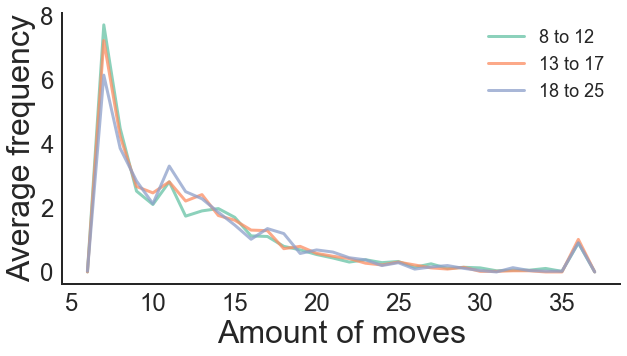

In [145]:
ax = plotdata.plot(color=["#66C2A5C0", "#FC8D62C0", "#8DA0CBC0"], figsize=(10, 5))
ax.legend(age_labels)
ax.set_xlabel("Amount of moves")
ax.set_ylabel("Average frequency")

## 2.3 opponent category

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


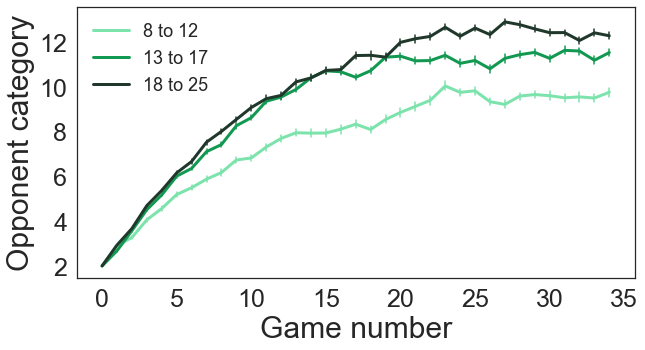

In [146]:
sns.set(style = "white", rc={'figure.figsize':(10,5), "font.size":25,"axes.titlesize":8,"axes.labelsize":30})
gcplot = sns.lineplot(
    data=gameCat, x="GameNr", y="Category", hue="ageBinNr", err_style="bars", ci=68,
    palette = age_colors, linewidth = 3
)
gcplot.set(xlabel='Game number', ylabel='Opponent category')
gcplot.legend(age_labels, fontsize='18')
gcplot.set_yticklabels(gcplot.get_yticks().astype(int), size = 25)
gcplot.set_xticklabels(gcplot.get_xticks().astype(int), size = 25)

plt.show()

# 3.0 Analyses 
## 3.1 Explore the metrics data in histograms and scatterplots

In [147]:
metrics.head()
meanMetrics = metrics.groupby(['subject']).mean()

Text(0, 0.5, 'Frequency')

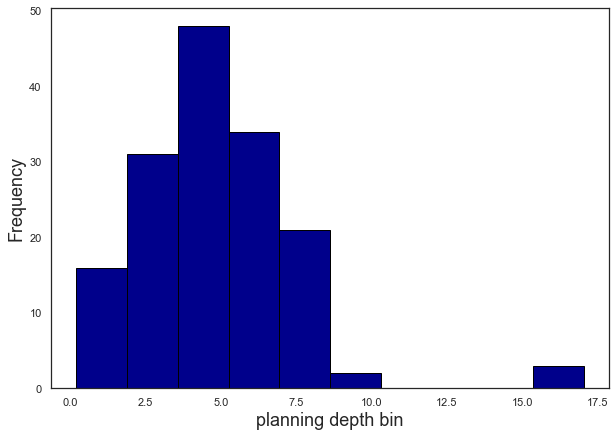

In [148]:
#histogram of the height
meanMetrics["planning depth"].plot(kind='hist', color='darkblue', edgecolor='black', figsize=(10,7))
plt.xlabel('planning depth bin', size=18)
plt.ylabel('Frequency', size=18)

Text(0, 0.5, 'Frequency')

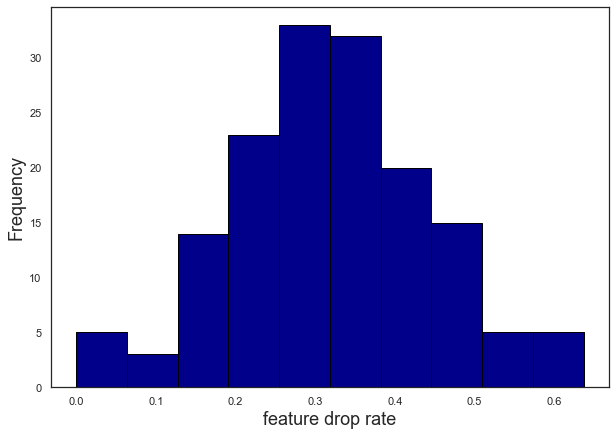

In [149]:
#histogram of the height
meanMetrics["feature drop rate"].plot(kind='hist', color='darkblue', edgecolor='black', figsize=(10,7))
plt.xlabel('feature drop rate', size=18)
plt.ylabel('Frequency', size=18)

Text(0, 0.5, 'Frequency')

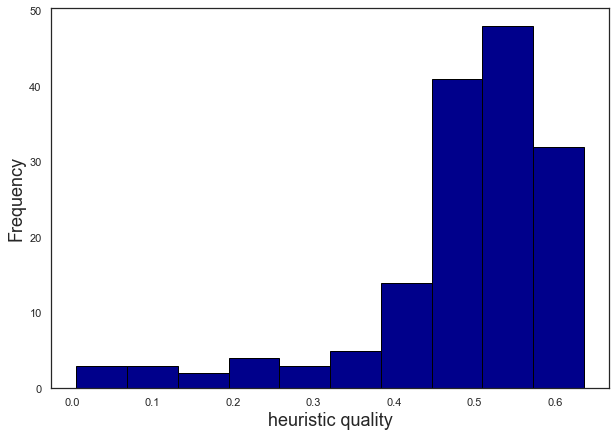

In [150]:
#histogram of the HQ
meanMetrics["heuristic quality"].plot(kind='hist', color='darkblue', edgecolor='black', figsize=(10,7))
plt.xlabel('heuristic quality', size=18)
plt.ylabel('Frequency', size=18)

<AxesSubplot:xlabel='heuristic quality', ylabel='planning depth'>

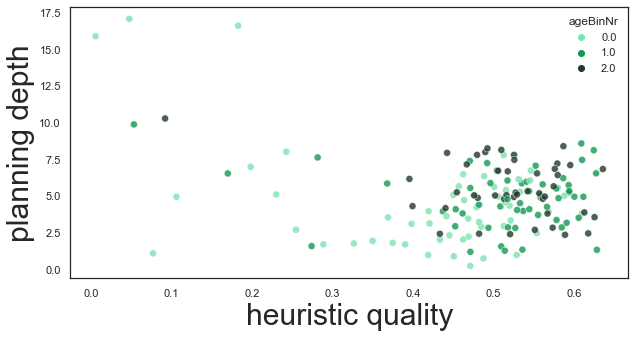

In [151]:
sns.scatterplot(data=meanMetrics, y="planning depth", x="heuristic quality", hue="ageBinNr", palette = age_colors,
                s=50, alpha = 0.8)

<AxesSubplot:xlabel='feature drop rate', ylabel='planning depth'>

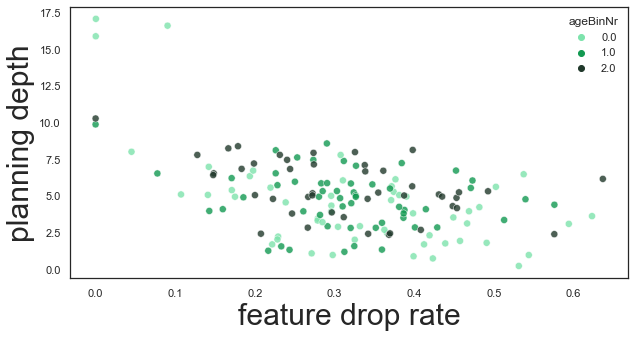

In [152]:
sns.scatterplot(data=meanMetrics, y="planning depth", x="feature drop rate", hue="ageBinNr", palette = age_colors,
               s=50, alpha = 0.8)

## 3.2 check metric stability and trade-off

In [157]:
 #get p values for correlation matrix
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues


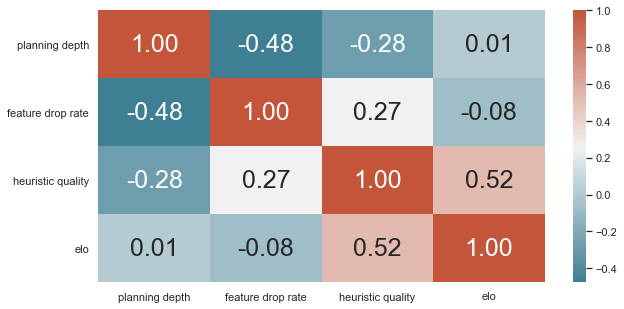

,planning depth,feature drop rate,heuristic quality,elo
planning depth,0,0,0.0004,0.9087
feature drop rate,0,0,0.0008,0.3446
heuristic quality,0.0004,0.0008,0,0
elo,0.9087,0.3446,0,0


In [167]:
# are the metrics correlated?
corrMetrics = meanMetrics.drop(["fold", 'ExactAge', 'FlooredAge', "ageBinNr", 'ageBinValue'], axis=1)
corrMatrix = corrMetrics.corr()
sns.heatmap(corrMatrix, annot=True, fmt='.2f', cmap = sns.diverging_palette(220, 20, as_cmap=True))
plt.show() 

calculate_pvalues(corrMetrics)
# answer: yes, except pd and fdr with elo

In [169]:
EloPlanning_model = np.polyfit(corrMatrix["planning depth"], corrMatrix.elo, 1)

array([-0.14209471,  0.37285286])

## 3.3 Residual plots

In [ ]:
#residual plots
sns.residplot(meanMetrics["planning depth"], meanMetrics.elo)
#sns.residplot(meanMetrics["heuristic quality"], meanMetrics.elo)
#sns.residplot(meanMetrics["feature drop rate"], meanMetrics.elo)



## 3.4 Regression metrics as function of age

In [179]:
normalized_df=(meanMetrics-meanMetrics.mean())/meanMetrics.std()

normalized_df.head()

#multiple regression between the model derived metrics using sklearn
mlr = LinearRegression() 
# fit linear regression
X = meanMetrics[['planning depth', 'heuristic quality', 'feature drop rate']]
Y = meanMetrics['elo']

mlr.fit(X, Y)
# get the slope and intercept of the line best fit.
#print(mlr.intercept_)
#print(mlr.coef_)
X2 = sm.add_constant(X)
est = sm.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    elo   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     24.62
Date:                Wed, 02 Jun 2021   Prob (F-statistic):           5.04e-13
Time:                        10:33:21   Log-Likelihood:                -951.70
No. Observations:                 155   AIC:                             1911.
Df Residuals:                     151   BIC:                             1924.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -181.5452     55.04

In [48]:
#multiple regression using sklearn
mlr = LinearRegression() 
# fit linear regression
X = meanMetrics[['feature drop rate', 'ExactAge']]
Y = meanMetrics['planning depth']

mlr.fit(X, Y)
# get the slope and intercept of the line best fit.
#print(mlr.intercept_)
#print(mlr.coef_)
X2 = sm.add_constant(X)
est = sm.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:         planning depth   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     24.18
Date:                Tue, 01 Jun 2021   Prob (F-statistic):           7.63e-10
Time:                        22:39:25   Log-Likelihood:                -347.20
No. Observations:                 155   AIC:                             700.4
Df Residuals:                     152   BIC:                             709.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 7.0781      0.77

In [47]:
meanMetrics.head()


,fold,planning depth,feature drop rate,heuristic quality,elo,ExactAge,FlooredAge,ageBinNr,ageBinValue
subject,,,,,,,,,
101:R_31SM3mwQvAhBwar,3,7.355170,0.311736,0.470505,227,17.4904,17.0,1.0,15.0
102:R_vdABJ1XvXNriwff,3,8.549830,0.290484,0.609139,179,15.0055,15.0,1.0,15.0
107:R_2ahKzS67s2u094R,3,2.200641,0.229306,0.469006,179,12.7260,12.0,0.0,10.0
117:R_2XpQzVOPaMJjkCo,3,3.947276,0.142905,0.536919,109,15.9315,15.0,1.0,15.0
121:R_2zoxitKzRuYUblm,3,4.877048,0.185704,0.558257,-9,14.4055,14.0,1.0,15.0


### 3.4.1 Exporting the dataframe for R

In [180]:
#Save dataframes to csv for R
#metrics.to_csv('../data/metrics.csv', index = False, header=True)
meanMetrics.to_csv('../data/meanMetrics.csv', index = False, header=True)


## 3.5 Plot elo as function of metrics

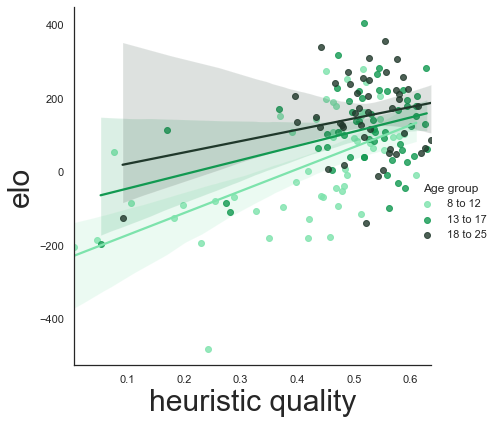

In [218]:
elo_hq_plot = sns.lmplot(data=meanMetrics, y="elo", x="heuristic quality", hue = "ageBinNr", palette = age_colors, height = 6)
new_title = 'Age group'
elo_hq_plot._legend.set_title(new_title)
new_labels = ['8 to 12', '13 to 17', '18 to 25']
for t, l in zip(elo_hq_plot._legend.texts, new_labels): t.set_text(l)


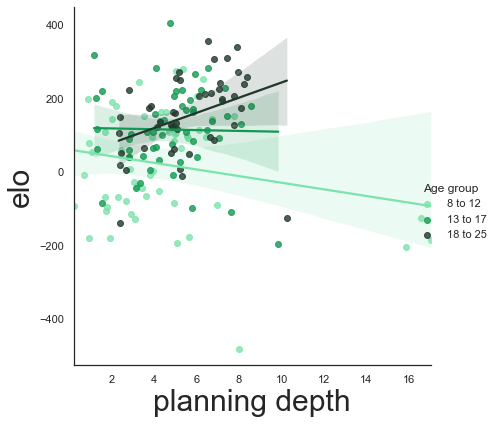

In [217]:
elo_hq_plot = sns.lmplot(data=meanMetrics, y="elo", x="planning depth", hue = "ageBinNr", palette = age_colors, height = 6)

new_title = 'Age group'
elo_hq_plot._legend.set_title(new_title)
new_labels = ['8 to 12', '13 to 17', '18 to 25']
for t, l in zip(elo_hq_plot._legend.texts, new_labels): t.set_text(l)


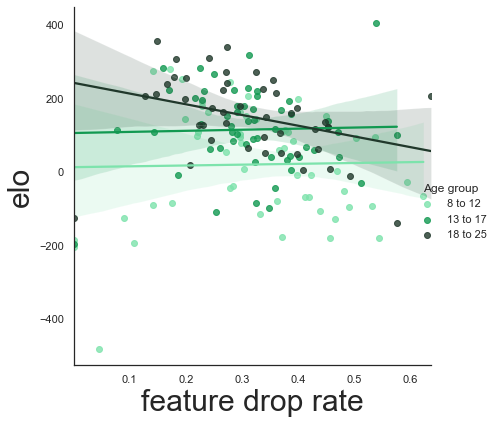

In [219]:
elo_hq_plot = sns.lmplot(data=meanMetrics, y="elo", x="feature drop rate", hue = "ageBinNr", palette = age_colors, height = 6)

new_title = 'Age group'
elo_hq_plot._legend.set_title(new_title)
new_labels = ['8 to 12', '13 to 17', '18 to 25']
for t, l in zip(elo_hq_plot._legend.texts, new_labels): t.set_text(l)


## 3.6 check model fit stability (NLL)

In [306]:
LL = pd.read_csv(datadir + "paramsLogLikelihoodsLong.csv")
NLL = pd.concat([LL, metrics], axis=1)
NLL = NLL.iloc[: , 2:]
NLL.to_csv('../data/NLL.csv', index = False, header=True)

### 3.6.1. NLL does not change as function of age
It's possible that younger children have parameter combinations that are less recoverable. The NLL did not seem to change as function of age suggests that this is not the case. 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


[Text(5.0, 0, '5'),
 Text(7.5, 0, '7'),
 Text(10.0, 0, '10'),
 Text(12.5, 0, '12'),
 Text(15.0, 0, '15'),
 Text(17.5, 0, '17'),
 Text(20.0, 0, '20'),
 Text(22.5, 0, '22'),
 Text(25.0, 0, '25'),
 Text(27.5, 0, '27')]

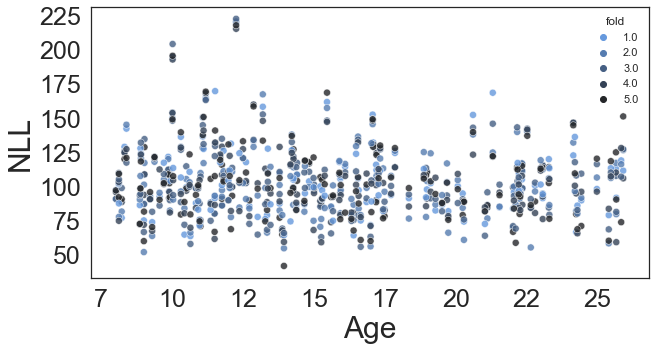

In [305]:

nll_plot = sns.scatterplot(data=NLL, y="nll", x="ExactAge", hue="fold", s=50, alpha = 0.8, palette = sns.dark_palette("#69d", reverse=True, as_cmap=True))
nll_plot.set(xlabel='Age', ylabel='NLL')
nll_plot.set_yticklabels(nll_plot.get_yticks().astype(int), size = 25)
nll_plot.set_xticklabels(nll_plot.get_xticks().astype(int), size = 25)

### 3.6.2 Check correlations between independent fits.
This is now done over two folds but should be changed to two full independent fits (i.e., 2 runs).

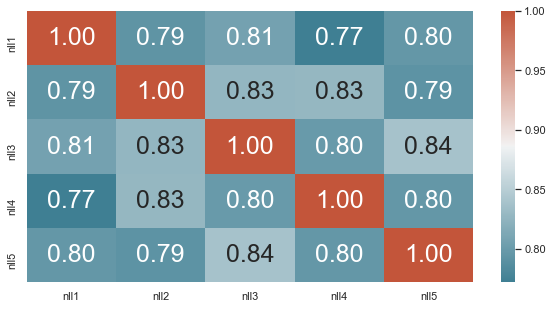

,nll1,nll2,nll3,nll4,nll5
nll1,0,0.5583,0.721,0.3704,0.6818
nll2,0.5583,0,0.8857,0.9242,0.483
nll3,0.721,0.8857,0,0.5746,0.8718
nll4,0.3704,0.9242,0.5746,0,0.6086
nll5,0.6818,0.483,0.8718,0.6086,0


In [309]:
# are the folds correlated?
NLL_wide 
corrNLL = NLL_wide.drop(["nll"], axis=1)
corrMatrixNLL = corrNLL.corr()
sns.heatmap(corrMatrixNLL, annot=True, fmt='.2f', cmap = sns.diverging_palette(220, 20, as_cmap=True))
plt.show() 

calculate_pvalues(corrMatrixNLL)
# answer: yes, except pd and fdr with elo

### Export the correlations to R for plotting
Unfortunately it was easier to plot this in R than in Python. The correlation coefficients outputted at the end of this are exported to R_notebook_for_plotting_results.ipynb to create the correlation between repeated fits plots.

In [362]:
age_info = metrics.drop(columns=['StudyID', "fold", 'feature drop rate', 'heuristic quality', "planning depth", "elo", "DoB", "Gender", "ExactAge", "FlooredAge", "TaskDate", "ageBin", "ageBinValue"])
age_info.head()
pwm = pd.read_csv(datadir + "params_with_metrics.csv")
pwm = pd.merge(pwm, age_info, on="subject", how="left")
pwm.ageBinNr.unique()

array([ 1.,  0., nan,  2.])

In [382]:
#Create dataframes for correlation matrix for correlation between repeated fits
df_allfolds = pwm.drop(columns=['feature drop rate', 'heuristic quality', "planning depth", "elo"])

def selectdataframe(ageBinNr, dataframe):
    df_fold1 = dataframe[dataframe['fold'] == 1]
    df_fold2 = dataframe[dataframe['fold'] == 2]
    return(df_fold1[df_fold1['ageBinNr'] == ageBinNr], df_fold2[df_fold2['ageBinNr'] == ageBinNr])
    

# create both fold dfs for children
df_fold1_child, df_fold2_child = selectdataframe(0.0, df_allfolds)

# create both fold dfs for adolescents
df_fold1_adol, df_fold2_adol = selectdataframe(1.0, df_allfolds)

# create both fold dfs for adults
df_fold1_adult, df_fold2_adult = selectdataframe(2.0, df_allfolds)

# merge dataframes for correlation matrix for correlation between repeated fits
def merge_runDfs(dataframe, dataframe2):
    df_fold1 = dataframe.rename(columns={"1": "pruning", "2": "stopping", "3": "feature drop", "4": "lapse", "5": "ac", "6": "center", "7": "2con", "8": "2uncon", "9": "three", "10": "four"})
    df_fold2 = dataframe2.rename(columns={"1": "pruning2", "2": "stopping2", "3": "feature drop2", "4": "lapse2", "5": "ac2", "6": "center2", "7": "2con2", "8": "2uncon2", "9": "three2", "10": "four2"})
    return pd.merge(df_fold1, df_fold2, on="subject", how="left")

# combine and name df across age
df_fold12 = merge_runDfs(df_fold1, df_fold2)

# combine and name df children
df_fold12_child = merge_runDfs(df_fold1_child, df_fold2_child)

# combine and name df adolescents
df_fold12_adol = merge_runDfs(df_fold1_adol, df_fold2_adol)

# combine and name df adults
df_fold12_adult = merge_runDfs(df_fold1_adult, df_fold2_adult)

In [423]:
# compute the correlation values to use in "correlation between repeated fits" in R

def corrValues(dataframe, header):
    print(header)
    for column_name in df_fold1:
        othername = column_name + "2"
        if othername in df_fold12:
            tempdataframe = df_fold12[[column_name, othername]].corr(method= "spearman")
            corr = tempdataframe.iloc[0][1]
            print(corr)
    print()

# are the folds correlated across age?
corrValues(df_fold12, "all")

# are the folds correlated for children?
corrValues(df_fold12_child, "children")

# are the folds correlated for adolescents?
corrValues(df_fold12_adol, "adolescents")

# are the folds correlated for adolescents?
corrValues(df_fold12_adult, "adults")

all
0.3119078853708816
0.2634839266491665
0.46086253833455826
0.007753914088900364
0.47069280119075174
0.716549777357099
0.4633066009050433
0.5070830079160122
0.28024705760689117
0.07442474782836964

children
0.3119078853708816
0.2634839266491665
0.46086253833455826
0.007753914088900364
0.47069280119075174
0.716549777357099
0.4633066009050433
0.5070830079160122
0.28024705760689117
0.07442474782836964

adolescents
0.3119078853708816
0.2634839266491665
0.46086253833455826
0.007753914088900364
0.47069280119075174
0.716549777357099
0.4633066009050433
0.5070830079160122
0.28024705760689117
0.07442474782836964

adults
0.3119078853708816
0.2634839266491665
0.46086253833455826
0.007753914088900364
0.47069280119075174
0.716549777357099
0.4633066009050433
0.5070830079160122
0.28024705760689117
0.07442474782836964

